Kaleb Flores, A01198716

Se importan todas las librerias que se van a usar

In [235]:
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.feature_selection import SequentialFeatureSelector as SFS
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.stattools import durbin_watson
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import het_breuschpagan, normal_ad
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

Se importan los datos

In [236]:
df = pd.read_csv("menu.csv")

Se hace un analísis de los datos que se tienen

In [237]:
df.head()

,Category,Item,Serving Size,Calories,Calories from Fat,Total Fat,Total Fat (% Daily Value),Saturated Fat,Saturated Fat (% Daily Value),Trans Fat,...,Carbohydrates,Carbohydrates (% Daily Value),Dietary Fiber,Dietary Fiber (% Daily Value),Sugars,Protein,Vitamin A (% Daily Value),Vitamin C (% Daily Value),Calcium (% Daily Value),Iron (% Daily Value)
0,Breakfast,Egg McMuffin,4.8 oz (136 g),300,120,13.0,20,5.0,25,0.0,...,31,10,4,17,3,17,10,0,25,15
1,Breakfast,Egg White Delight,4.8 oz (135 g),250,70,8.0,12,3.0,15,0.0,...,30,10,4,17,3,18,6,0,25,8
2,Breakfast,Sausage McMuffin,3.9 oz (111 g),370,200,23.0,35,8.0,42,0.0,...,29,10,4,17,2,14,8,0,25,10
3,Breakfast,Sausage McMuffin with Egg,5.7 oz (161 g),450,250,28.0,43,10.0,52,0.0,...,30,10,4,17,2,21,15,0,30,15
4,Breakfast,Sausage McMuffin with Egg Whites,5.7 oz (161 g),400,210,23.0,35,8.0,42,0.0,...,30,10,4,17,2,21,6,0,25,10


In [238]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Category                       260 non-null    object 
 1   Item                           260 non-null    object 
 2   Serving Size                   260 non-null    object 
 3   Calories                       260 non-null    int64  
 4   Calories from Fat              260 non-null    int64  
 5   Total Fat                      260 non-null    float64
 6   Total Fat (% Daily Value)      260 non-null    int64  
 7   Saturated Fat                  260 non-null    float64
 8   Saturated Fat (% Daily Value)  260 non-null    int64  
 9   Trans Fat                      260 non-null    float64
 10  Cholesterol                    260 non-null    int64  
 11  Cholesterol (% Daily Value)    260 non-null    int64  
 12  Sodium                         260 non-null    int

Se observa que existe una relación entre calorias y grasas

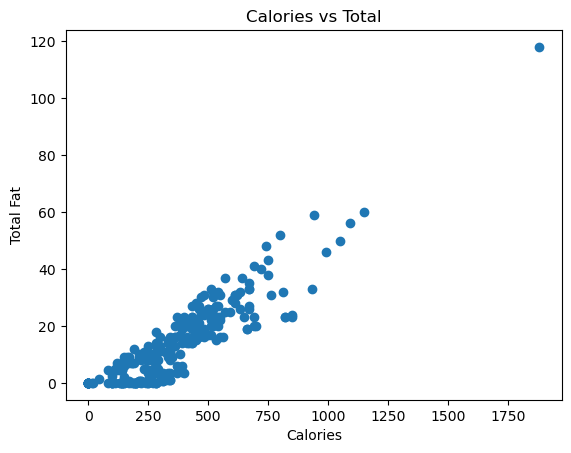

In [239]:
plot = plt.scatter("Calories", "Total Fat", data=df)
plt.title("Calories vs Total")
plt.xlabel("Calories")
plt.ylabel("Total Fat")
plt.show()

Se eligen las posibles variables que pueden usarse para predecir las calorias

In [240]:
X = df[["Total Fat","Carbohydrates","Protein", "Sodium"]]
y = df["Calories"]

# Modelo 1, regresión lineal

Se usa la función train_test_split para dividir los datos en entrenamiento y prueba

In [241]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

Se inicia el modelo de regresión lineal y se usa el sequential feature selection para seleccionar las variables más importantes para el modelo

In [242]:
linear_regression = LinearRegression()
sfs1 = SFS(linear_regression, n_features_to_select=3, direction='forward',cv=5)
sfs1.fit(X_train, y_train)

SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select=3)

Se transforman los datos de entrenamiento y prueba para que se ajusten al modelo

In [243]:
X_train_select= sfs1.transform(X_train)
X_test_select = sfs1.transform(X_test)
linear_regression.fit(X_train_select, y_train)

LinearRegression()

Se usa el modelo para predecir los datos y se guarda la correlación que tiene con los datos

In [244]:
y_pred = linear_regression.predict(X_test_select)
linear_residuals = y_test - y_pred

linear_score = r2_score(y_test, y_pred)

Se obtienen los coeficietes de la regresión

In [245]:
coef = pd.DataFrame(linear_regression.coef_, X.columns[sfs1.get_support()], ["Coefs"])
coef

,Coefs
Total Fat,9.002998
Carbohydrates,3.988871
Protein,4.054709


calories = 9 * fat + 4 * carbs + 4 * protein

Se checan 5 datos al azar para ver que tan bien se ajusta el modelo

In [246]:
results = pd.DataFrame({"Real": y_test, "Predicted values": y_pred})
results = results.sample(n = 20)
results.head()

,Real,Predicted values
92,330,325.316415
158,330,323.981491
204,250,258.541757
33,990,992.712426
196,140,134.196140


Se modelan los datos reales vs los datos predichos

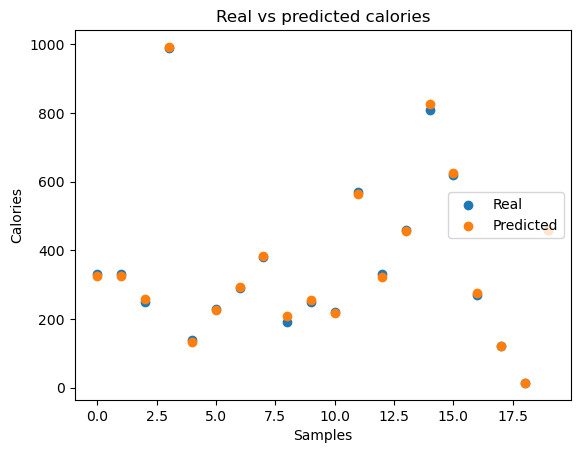

In [247]:
plt.scatter(np.arange(20), results["Real"], label="Real")
plt.scatter(np.arange(20), results["Predicted values"], label="Predicted")
plt.title("Real vs predicted calories")
plt.legend(loc="center right")
plt.xlabel("Samples")
plt.ylabel("Calories")
plt.show()

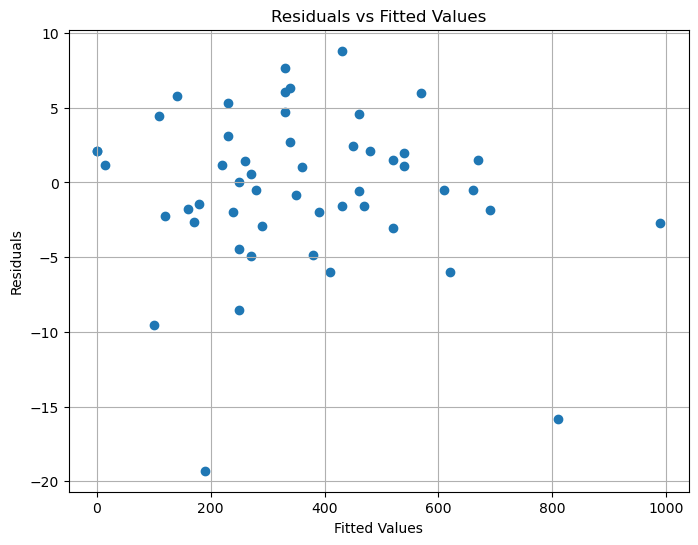

<Figure size 800x600 with 0 Axes>

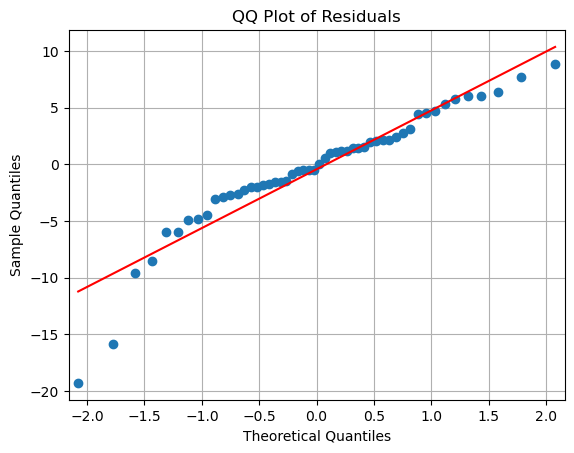

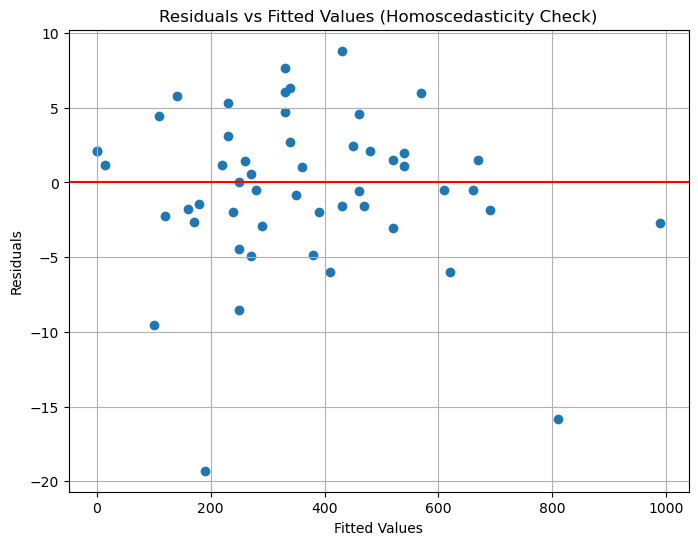

In [248]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, linear_residuals)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# Plot histogram of residuals
#plt.figure(figsize=(8, 6))
#sns.histplot(linear_residuals, kde=True, bins=10)
#plt.title('Histogram of Residuals')
#plt.xlabel('Residuals')
#plt.ylabel('Frequency')
#plt.grid(True)
#plt.show()

# Plot QQ plot of residuals
plt.figure(figsize=(8, 6))
sm.qqplot(linear_residuals, line='s')
plt.title('QQ Plot of Residuals')
plt.grid(True)
plt.show()

# Check homoscedasticity using predicted values and residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_test, linear_residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals vs Fitted Values (Homoscedasticity Check)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# Polinomial multivariante

Se usa polinomial features para hacer modificar los datos de manera que se pueda realizar una regresión polinomial, se dividen los datos y se ajustan las variables al modelo con una elección hacia adelantes de las variables

In [249]:
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
poly_variables = poly.fit_transform(X)

Xpoly_train, Xpoly_test, ypoly_train, ypoly_test = train_test_split(poly_variables, y, test_size = 0.2, random_state = 42)

regression = LinearRegression()
sfs2 = SFS(regression, n_features_to_select=7, direction='backward',cv=5)
sfs2.fit(Xpoly_train, ypoly_train)

sfs2.get_support()
Xpoly_train_select = Xpoly_train[:,sfs2.get_support()]
Xpoly_test_select = Xpoly_test[:,sfs2.get_support()]
regression.fit(Xpoly_train_select, ypoly_train)



LinearRegression()

Se usa el modelo obtenido para predecir las variables y se obtiene su correlación

In [250]:
y_pred = regression.predict(Xpoly_test_select)

score_poly = r2_score(ypoly_test, y_pred)
score_poly
residuals_poly = ypoly_test - y_pred

Se grafican los valores reales contra los valores predichos

In [251]:
results = pd.DataFrame({"Real": ypoly_test, "Predicted values": y_pred})
results = results.sample(n = 20)
results.head()

,Real,Predicted values
45,610,610.093969
228,670,667.768279
205,120,122.547407
92,330,325.238059
77,380,384.684829


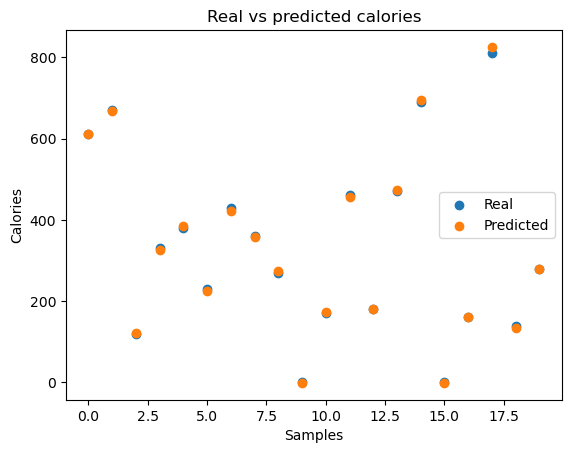

In [252]:
plt.scatter(np.arange(20), results["Real"], label="Real")
plt.scatter(np.arange(20), results["Predicted values"], label="Predicted")
plt.title("Real vs predicted calories")
plt.legend(loc="center right")
plt.xlabel("Samples")
plt.ylabel("Calories")
plt.show()

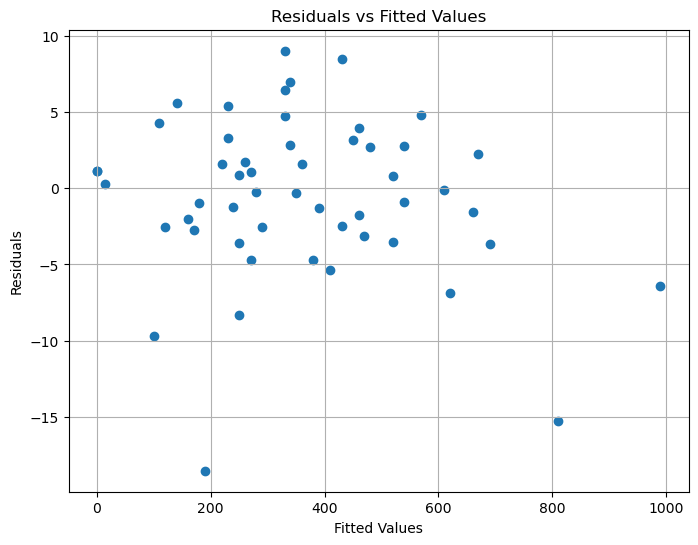

<Figure size 800x600 with 0 Axes>

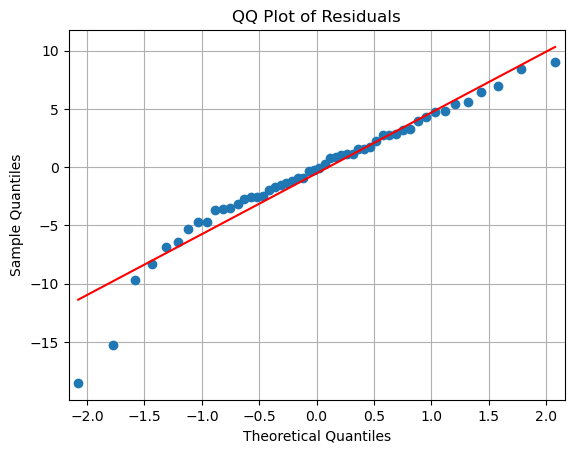

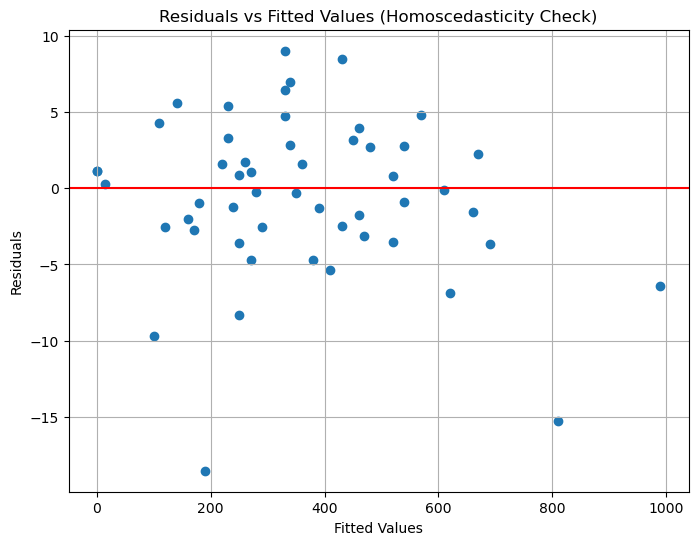

In [253]:
plt.figure(figsize=(8, 6))
plt.scatter(ypoly_test, residuals_poly)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# Plot histogram of residuals
#plt.figure(figsize=(8, 6))
#sns.histplot(linear_residuals, kde=True, bins=10)
#plt.title('Histogram of Residuals')
#plt.xlabel('Residuals')
#plt.ylabel('Frequency')
#plt.grid(True)
#plt.show()

# Plot QQ plot of residuals
plt.figure(figsize=(8, 6))
sm.qqplot(residuals_poly, line='s')
plt.title('QQ Plot of Residuals')
plt.grid(True)
plt.show()

# Check homoscedasticity using predicted values and residuals
plt.figure(figsize=(8, 6))
plt.scatter(ypoly_test, residuals_poly)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals vs Fitted Values (Homoscedasticity Check)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# Polinomial mutivariante con interacción

Se usa polinomial features para hacer modificar los datos de manera que se pueda realizar una regresión polinomial con interacción, se dividen los datos y se ajustan las variables al modelo con una elección hacia adelante de las variables

In [254]:
poly_interac = PolynomialFeatures(degree=3, interaction_only=True)
poly_interac_variables = poly.fit_transform(X)

Xpoly_interac_train, Xpoly_interac_test, ypoly_interac_train, ypoly_interac_test = train_test_split(poly_interac_variables, y, test_size = 0.2, random_state = 42)

regression = LinearRegression()
sfs3 = SFS(regression, n_features_to_select=8, direction='backward',cv=5)

sfs3.fit(Xpoly_interac_train, ypoly_interac_train)
Xpoly_interac_train_selec = Xpoly_interac_train[:,sfs3.get_support()]
regression.fit(Xpoly_interac_train_selec, ypoly_interac_train)
Xpoly_interac_test_selec = Xpoly_interac_test[:,sfs3.get_support()]
y_pred = regression.predict(Xpoly_interac_test_selec)


Se guarda la correlación obtenida y los residuales

In [255]:
score_interac = r2_score(ypoly_interac_test, regression.predict(Xpoly_interac_test[:,sfs3.get_support()]))
residuals_interac = ypoly_interac_test - y_pred

In [256]:
results = pd.DataFrame({"Real": ypoly_interac_test, "Predicted values": y_pred})
results = results.sample(n = 20)
results.head()

,Real,Predicted values
45,610,609.785366
212,350,350.776788
158,330,324.049052
150,280,280.055332
185,390,391.677931


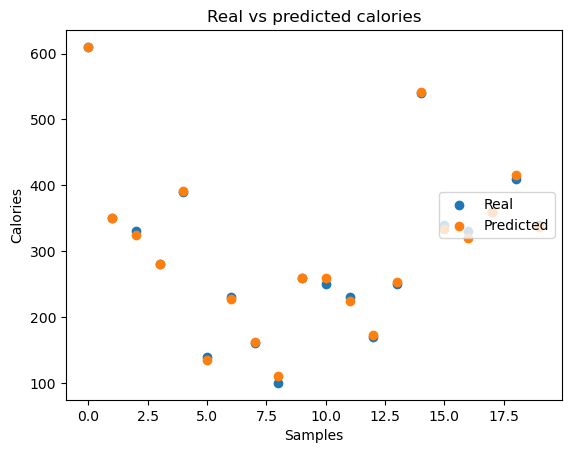

In [257]:
plt.scatter(np.arange(20), results["Real"], label="Real")
plt.scatter(np.arange(20), results["Predicted values"], label="Predicted")
plt.title("Real vs predicted calories")
plt.legend(loc="center right")
plt.xlabel("Samples")
plt.ylabel("Calories")
plt.show()

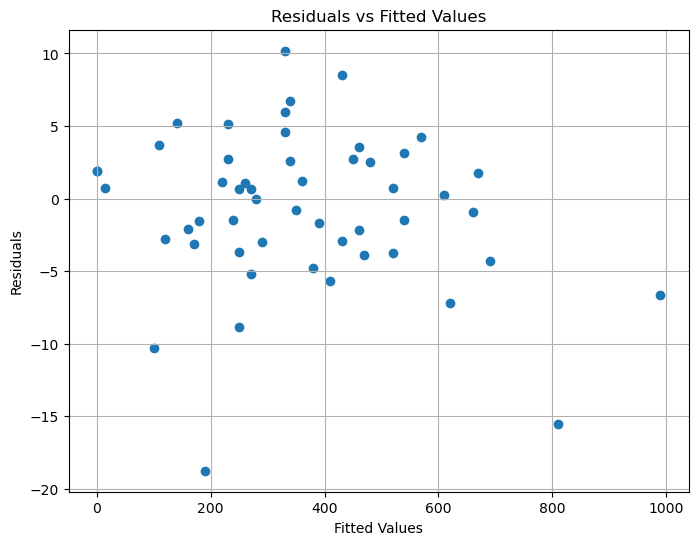

<Figure size 800x600 with 0 Axes>

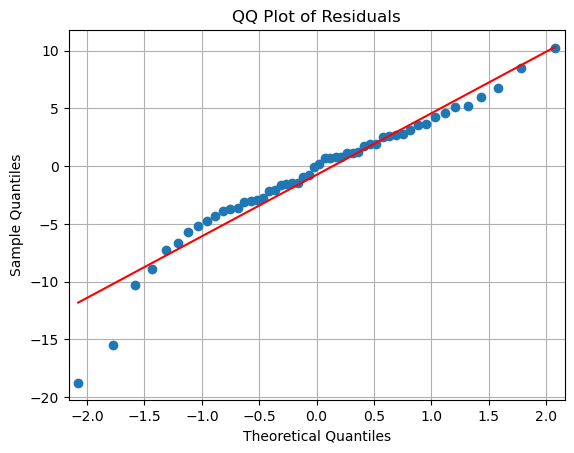

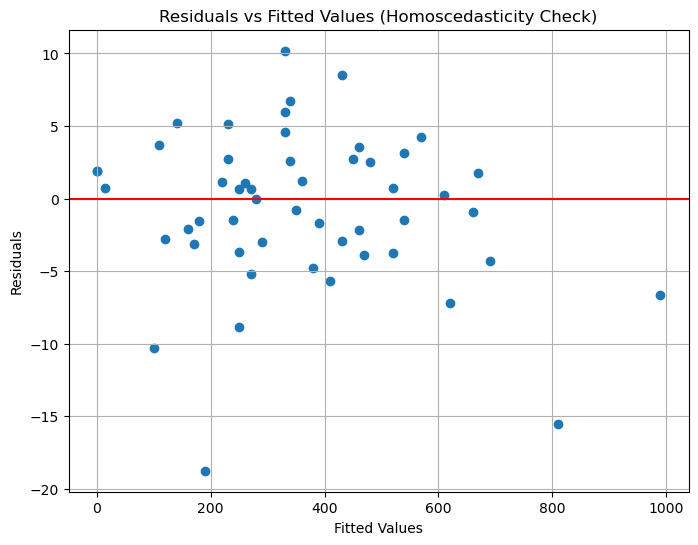

In [258]:
plt.figure(figsize=(8, 6))
plt.scatter(ypoly_interac_test, residuals_interac)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# Plot histogram of residuals
#plt.figure(figsize=(8, 6))
#sns.histplot(linear_residuals, kde=True, bins=10)
#plt.title('Histogram of Residuals')
#plt.xlabel('Residuals')
#plt.ylabel('Frequency')
#plt.grid(True)
#plt.show()

# Plot QQ plot of residuals
plt.figure(figsize=(8, 6))
sm.qqplot(residuals_interac, line='s')
plt.title('QQ Plot of Residuals')
plt.grid(True)
plt.show()

# Check homoscedasticity using predicted values and residuals
plt.figure(figsize=(8, 6))
plt.scatter(ypoly_interac_test, residuals_interac)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals vs Fitted Values (Homoscedasticity Check)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

In [259]:
# Getting R2 score for the models
print("R2 score for linear model: ", linear_score)
print("R2 score for polynomial model: ", score_poly)
print("R2 score for polynomial interaction model: ", score_interac)


def r2_adjusted(r2, n, p):
    adjust_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return adjust_r2
# R2 score adjusted
n = len(y_test)
p = 4
print("Adjusted r2 score for linear model: ", r2_adjusted(linear_score, n, p))
print("Adjusted r2 score for polynomial model: ", r2_adjusted(score_poly, n, p))
print("Adjusted r2 score for polynomial interaction model: ", r2_adjusted(score_interac, n, p))


R2 score for linear model:  0.9993428663117916
R2 score for polynomial model:  0.9993332372573884
R2 score for polynomial interaction model:  0.9993001661986994
Adjusted r2 score for linear model:  0.9992869400404547
Adjusted r2 score for polynomial model:  0.9992764914920598
Adjusted r2 score for polynomial interaction model:  0.9992406058751845


In [260]:
X_test_select = sm.add_constant(X_test_select)
Xpoly_test_select = sm.add_constant(pd.DataFrame(Xpoly_test_select))
Xpoly_interac_test_selec = sm.add_constant(pd.DataFrame(Xpoly_interac_test_selec))


def tests(residuals,x, p):
    print("Model:",p)
    # Normality test
    print("Normality test: ", normal_ad(residuals)[1])
    # Homoscedasticity test
    print("Homoscedasticity test: ", het_breuschpagan(residuals, x)[1])
    # Autocorrelation test
    print("Autocorrelation test: ", durbin_watson(residuals))
    print("-------------------------------------------\n")
tests(linear_residuals, X_test_select,1)
tests(residuals_poly, Xpoly_test_select,2)
tests(residuals_interac, Xpoly_interac_test_selec,3)

Model: 1
Normality test:  0.009307864601393875
Homoscedasticity test:  0.08886406429412862
Autocorrelation test:  2.252001309025355
-------------------------------------------

Model: 2
Normality test:  0.09367055880764223
Homoscedasticity test:  0.1878991225852459
Autocorrelation test:  2.357256199775753
-------------------------------------------

Model: 3
Normality test:  0.08185715331327341
Homoscedasticity test:  0.2501210280187251
Autocorrelation test:  2.3499447089233803
-------------------------------------------



En este caso se observa que dos un modelos cumplen con los supuestos de:

Linealidad de errores

Homocedasticidad de errores

Independencia de errores y

Normalidad de errores, 

Estos modelos son el de regresión polinomial con interacción y sin interacción, por lo que se pueden usar para predecir los datos.
El modelo de regresión lineal no cumplen con el supuesto de normalidad de errores y es por esto que no pueden ser usados para predecir los datos.

# 